<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7
## Minjie Yang(my189)
 Link to reference code:https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb

 Link to github:https://github.com/AndreYang333/ExplainableAI.git

# Code Part

In [1]:
# We are going to clone the tcav repo in GitHub:
!git clone https://github.com/tensorflow/tcav.git tcav
%cd tcav
!ls

# Next, we will create the datasets
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=Minjie --number_of_images_per_folder=10 --number_of_random_folders=20

%cd /content/tcav

Cloning into 'tcav'...
remote: Enumerating objects: 709, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 709 (delta 4), reused 1 (delta 0), pack-reused 697 (from 1)
Receiving objects: 100% (709/709), 639.02 KiB | 5.56 MiB/s, done.
Resolving deltas: 100% (405/405), done.
/content/tcav
CONTRIBUTING.md        LICENSE	  requirements.txt  Run_TCAV_on_colab.ipynb  tcav
FetchDataAndModels.sh  README.md  Run_TCAV.ipynb    setup.py
/content/tcav/tcav/tcav_examples/image_models/imagenet
Created source directory at Minjie
Downloaded 10 for zebra
Successfully created data at Minjie
/content/tcav


In [2]:
!pip install tcav matplotlib==2.2.4 Pillow==8.2.0 scikit-learn==0.20.3 scipy==1.2.1 tensorflow==2.14.1 numpy==1.19.2 protobuf==3.10.0 pandas==1.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 61.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error 

In [3]:
# Basic
import os
import absl
import random
import matplotlib.pyplot as plt
from PIL import Image

# Models
import tensorflow as tf

#XAI
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot


## Curate + store data
source_dir: directories for images of concepts, target class and random images. Each should be a sub-folder within this directory.

You need roughly 50-200 images per concept and target class (10-20 will work, but 200 is recommended by original paper authors).
cav_dir: directory to store CAVs (None if you don't want to store)

target, concept: names of the target class and concepts (strings) - these are folder names in source_dir

bottlenecks: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV

In [4]:
# Model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# Name of the parent directory that results are stored (if cacheing)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# Location where activations are stored
activation_dir =  working_dir+ '/activations/'
# Location where CAVs are stored (or None if not storing)
cav_dir = working_dir + '/cavs/'
# Location of images
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie'
# Bottleneck layer
bottlenecks = ['mixed4c']

# Create directories if they don't exist
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# Regularizer penalty parameter for linear classifier to get CAVs
alphas = [0.1]

target = 'zebra'
concepts = ["dotted","striped","zigzagged"]


In [5]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224' '/content/tcav/tcav/mobilenet_v2_1.0_224'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224'


'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224' -> '/content/tcav/tcav/mobilenet_v2_1.0_224'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_

In [6]:

%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h' -> '/content/tcav/tcav/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/LICENSE'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h': Is a directory


## Visualize Images from the Target, Concepts, and Random folders

Images from target folder:


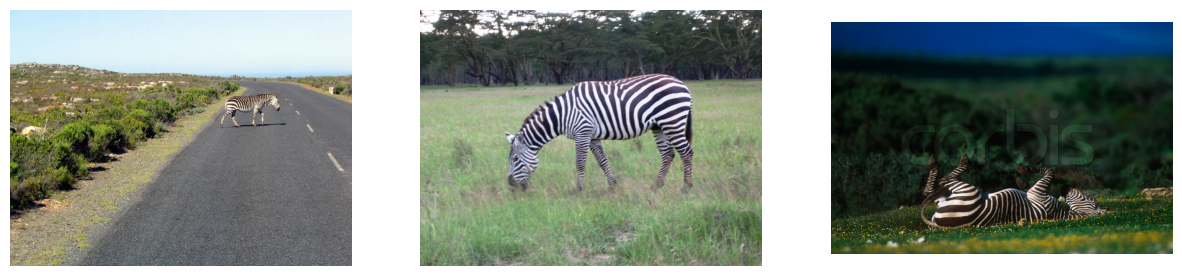

Images from dotted folder:


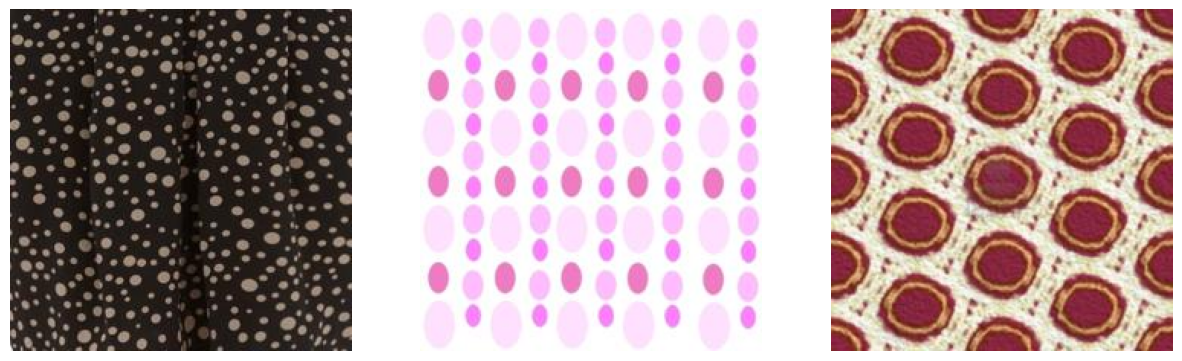

Images from striped folder:


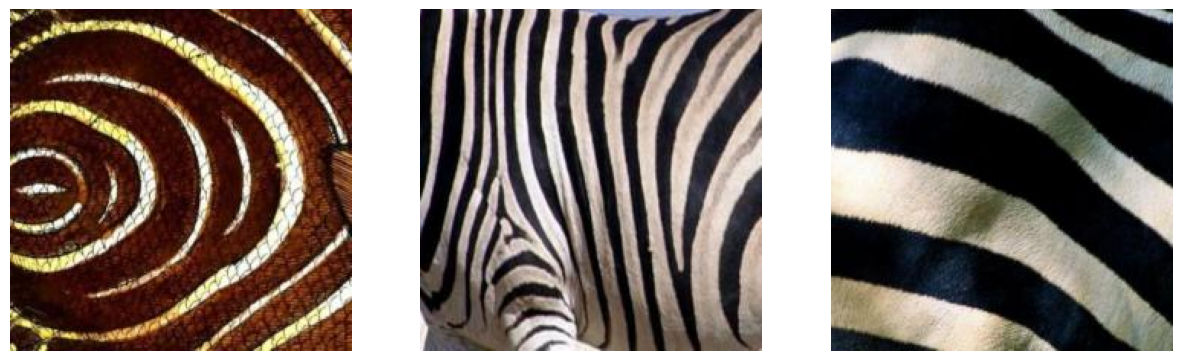

Images from zigzagged folder:


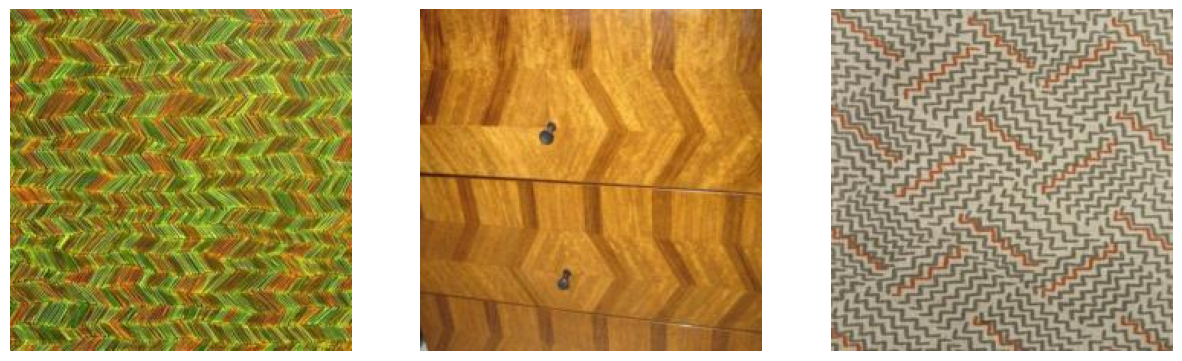

Images from random folder:


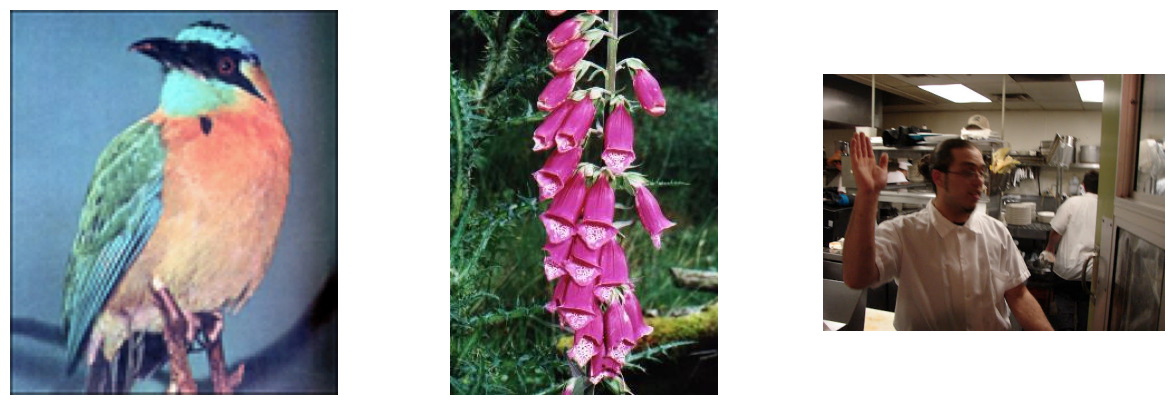

In [7]:
def display_random_images(directory, num_images):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Filter out non-image files
    image_files = [f for f in files if f.endswith('.jpg')]

    # Check if there are enough image files
    if len(image_files) < num_images:
        print(f"Not enough images in {directory}.")
        return

    # Select random images
    random_images = random.sample(image_files, num_images)

    # Display selected images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

# Define source directory
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie'
target = 'zebra'
concepts = ["dotted","striped","zigzagged"]
random_folder = 'random500_10'

# Display 3 images from the target folder in a row
print("Images from target folder:")
display_random_images(os.path.join(source_dir, target), 3)

# Display 3 images from each concept folder
for concept in concepts:
    print(f"Images from {concept} folder:")
    display_random_images(os.path.join(source_dir, concept), 3)

# Display 3 images from a random folder
print("Images from random folder:")
display_random_images(os.path.join(source_dir, random_folder), 3)


## Model Wrapper
See below for instructions on creating your own.

GRAPH_PATH is where the trained model is stored. LABEL_PATH is where the labels are stored

In [8]:
sess = utils.create_session() # a tensorflow session

GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,GRAPH_PATH,LABEL_PATH)

## Return Avtivations

In [9]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## Run TCAV and show results

In [11]:
absl.logging.set_verbosity(0)
num_random_exp=20  # Recommend >10
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#50)
print ('Started')
results = mytcav.run(run_parallel=False)
print ('Completed')

Started


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Completed


Class = zebra
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.40 (+- 0.19), random was 0.50 (+- 0.27). p-val = 0.104 (not significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.81 (+- 0.19), random was 0.50 (+- 0.27). p-val = 0.000 (significant)
  Concept = zigzagged
    Bottleneck = mixed4c. TCAV Score = 0.75 (+- 0.16), random was 0.50 (+- 0.27). p-val = 0.000 (significant)
{'mixed4c': {'bn_vals': [0.01, 0.8125, 0.75], 'bn_stds': [0, 0.1875, 0.15811388300841897], 'significant': [False, True, True]}}


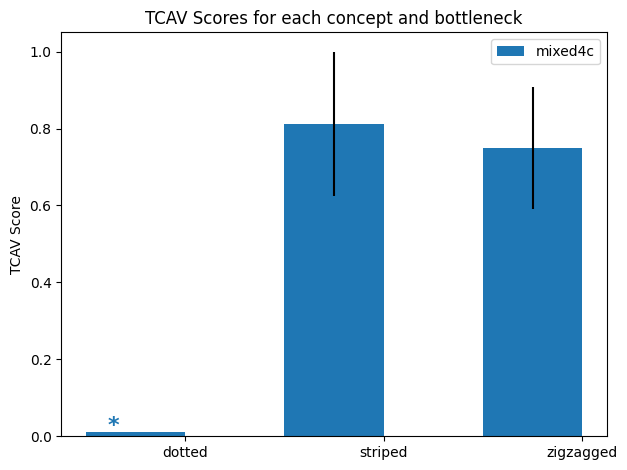

In [12]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)


# Statistical Part

## Hypothesis:
H0: The GoogleNet model does not show a significant difference in its ability to learn the concept "zigzagged" compared to the concept "dotted" for the class ‘zebra’.



H1: The GoogleNet model shows a significant difference in its ability to learn the concept "zigzagged" compared to the concept "dotted" for the class ‘zebra’.

In [13]:
import numpy as np
from scipy import stats

zigzagged_scores = [r['i_up'] for r in results if r['cav_concept'] == 'zigzagged']
dotted_scores = [r['i_up'] for r in results if r['cav_concept'] == 'dotted']


In [14]:
t_stat, p_value = stats.ttest_ind(zigzagged_scores, dotted_scores)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("We can reject H0")
else:
    print("We cannot reject H0")

T-statistic: 6.133201579612528, P-value: 3.7380323383255906e-07
We can reject H0


According to the results above, we can reject H0 at 1% significance level, which means The GoogleNet model shows a significant difference in its ability to learn the concept "zigzagged" compared to the concept "dotted" for the class ‘zebra’.

# Explanation Part
## CAV：
Concept Activation Vectors (CAVs) are a method used in interpretable machine learning to quantify how much a neural network relies on human-understandable concepts for making predictions. CAVs work by defining a direction in the network's internal activation space that corresponds to a particular concept, such as "striped" or "dotted." This direction is learned by training a linear classifier to distinguish between activations caused by images that contain the concept and those that do not. Once the CAV is computed, it can be used to assess how sensitive the model's predictions are to changes in the direction of that concept. The directional derivative along the CAV indicates whether the concept has a positive or negative influence on the model's output for a given class. CAVs enable insights into what the model has learned in terms of interpretable concepts.

## Implementation
For any given concept, TCAV measures the extent of that concept’s influence on the model’s prediction for a certain class

Concept Activation Vectors (CAV) are a numerical representation of a concept in the activation space of a neural network layer

Implementation:

1. Curate two datasets

  A concept dataset that represents concept C

  A random dataset
2. Target a hidden layer 𝑙 and train a binary classifier which separates the activations generated by the concept set from those generated by the random set

  The binary classifier can be an SVM or logistic regression model

  The coefficient vector of this trained binary classifier is the CAV, vlc

3. Given an image input 𝑥, we can measure its conceptual sensitivity by calculating the directional derivative of the prediction in the direction of the unit CAV

## Interesting Findings


- The concept **"dotted"** has a near-zero TCAV score, which indicates that the model does not rely on this concept when making predictions for the target class. In contrast, both **"striped"** and **"zigzagged"** have significantly higher TCAV scores, suggesting that the model strongly depends on these two concepts.
- The **"striped"** concept has the highest TCAV score (close to 0.9), implying that the model most strongly associates this concept with the target class.
- Interestingly, the **"zigzagged"** concept also shows a high TCAV score, comparable to "striped," which suggests that the model has learned to associate this pattern with the target class as well, even though the two concepts represent visually different patterns.
